In [86]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from art.utils import load_mnist, preprocess

import copy
from collections import defaultdict
import itertools
import math
#from pyhessian import hessian

from utils.model import FLNet
from utils.local_train import LocalTraining
from utils.utils import Utils
from utils.fusion import Fusion, FusionAvg, FusionRetrain

#seeds
torch.manual_seed(0)
np.random.seed(0)

#### FL Fusion Class Selection

In [87]:
def FL_round_fusion_selection(num_parties, fusion_key='FedAvg'):

    fusion_class_dict = {
        'FedAvg': FusionAvg(num_parties),
        'Retrain': FusionRetrain(num_parties),
        'Unlearn': FusionAvg(num_parties)
        }

    return fusion_class_dict[fusion_key]

#### Set up No. of Parties, Party to be Erased, and Attack Parameters

In [88]:
num_parties = 5
scale = 1

party_to_be_erased = 0
num_samples_erased_party = int(60000 / num_parties * scale)
num_samples_per_party = int((60000 - num_samples_erased_party)/(num_parties - 1))
print('Number of samples erased party:', num_samples_erased_party)
print('Number of samples other party:', num_samples_per_party)

Number of samples erased party: 12000
Number of samples other party: 12000


### 2. Load data
<a id='section_2'></a>

**Note:** We use the backdoor triggers (Gu et al., 2017) as an effective way to evaluate the performance of unlearning methods. In particular, the target client uses a dataset with a certain fraction of images which have a backdoor trigger inserted in them. Thus, the global FL model becomes susceptible to the backdoor trigger. Then, a successful unlearning process should produce a model that reduces the accuracy on the images with the backdoor trigger, while
maintaining a good performance on regular (clean) images. Note that we use the backdoor triggers as a way to evaluate the performance of unlearning methods; we do not consider any malicious client.

Load ART

In [89]:

import art
from art.attacks.poisoning import PoisoningAttackBackdoor, PoisoningAttackCleanLabelBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd

Load MNIST from ART

In [90]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

x_train, y_train = preprocess(x_raw, y_raw)
x_test, y_test = preprocess(x_raw_test, y_raw_test)

n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

Create Trainloader

In this Notebook we are going to create it by the following principle:
 - Each client will have 50% of it's dataset given by classes common among all the clients
 - Remaining 50% will be given to each client and will be different among different clients

Example:
client 3 will have 50% given by the labels: [0,1,2,3,4]. 50% will be with data coming just from the label [7]

In [91]:
all_indices = np.arange(len(y_train))
i = all_indices[np.sum(y_train*np.array([1,1,1,1,1,0,0,0,0,0]), axis = 1).astype(bool)]
list_indices = np.split(i[:5*(len(i)//5)], 5)

In [92]:
for j in range(5,10):
  label = [0,0,0,0,0,0,0,0,0,0]
  label[j] = 1
  indx = all_indices[np.sum(y_train*np.array(label), axis = 1).astype(bool)]
  list_indices[j-5] = np.concatenate((list_indices[j-5], all_indices[indx]))

In [93]:
x_train_ch = np.expand_dims(x_train, axis=1)
y_train_c = np.argmax(y_train, axis=1).astype(int)
print(x_train_ch.shape)
print(y_train_c.shape)
trainloader_lst = []
for indices in list_indices:
  ds = TensorDataset(torch.Tensor(x_train_ch[indices]), torch.Tensor(y_train_c[indices]).long())
  trainloader_lst.append(DataLoader(ds, batch_size=128, shuffle=True))

(60000, 1, 28, 28)
(60000,)


In [94]:
x_test_pt = np.expand_dims(x_test, axis = 1)
y_test_pt = np.argmax(y_test,axis=1).astype(int)
print(x_test_pt.shape)
print(y_test_pt.shape)
dataset_test = TensorDataset(torch.Tensor(x_test_pt), torch.Tensor(y_test_pt).long())
testloader = DataLoader(dataset_test, batch_size=1000, shuffle=False)

(10000, 1, 28, 28)
(10000,)


## 2. Train the FL Model
<a id='section_3'></a>

In [95]:
num_of_repeats = 1
num_fl_rounds = 50

#fusion_types = ['FedAvg','Retrain']
fusion_types = ['FedAvg']
fusion_types_unlearn = ['Retrain', 'Unlearn']

num_updates_in_epoch = None
num_local_epochs = 1

dist_Retrain = {}
loss_fed = {}
grad_fed = {}
clean_accuracy = {}
pois_accuracy = {}
for fusion_key in fusion_types:
    loss_fed[fusion_key] = np.zeros(num_fl_rounds)
    grad_fed[fusion_key] = np.zeros(num_fl_rounds)
    clean_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    pois_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    if fusion_key != 'Retrain':
        dist_Retrain[fusion_key] = np.zeros(num_fl_rounds)

Train and evaluate the FL Model

In [96]:
class FLNet2(nn.Sequential):
    def __init__(self):
        super(FLNet2, self).__init__(
            nn.Conv2d(1, 32, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
party_models_dict = {}
initial_model = FLNet2()
model_dict = {}

for fusion_key in fusion_types:
    model_dict[fusion_key] = copy.deepcopy(initial_model.state_dict())

for round_num in range(num_fl_rounds):
    local_training = LocalTraining(num_updates_in_epoch=num_updates_in_epoch, num_local_epochs=num_local_epochs)

    for fusion_key in fusion_types:
        fusion = FL_round_fusion_selection(num_parties=num_parties, fusion_key=fusion_key)

        current_model_state_dict = copy.deepcopy(model_dict[fusion_key])
        current_model = copy.deepcopy(initial_model)
        current_model.load_state_dict(current_model_state_dict)

        ##################### Local Training Round #############################
        party_models = []
        party_losses = []
        party_grad   = []        
        for party_id in range(num_parties):

            if fusion_key == 'Retrain':
                break
            else:
                model = copy.deepcopy(current_model).to(device)
                model_update, party_loss = local_training.train(model=model,
                                            trainloader=trainloader_lst[party_id],
                                            device = device,
                                            criterion=None, opt=None)

                party_models.append(copy.deepcopy(model_update))
                party_losses.append(party_loss)

            grad_norm = 0.0
            for param in model_update.parameters():
                if param.grad is not None:
                    grad_norm += torch.norm(param.grad).item()
        
            party_grad.append(grad_norm)   
        
        grad_fed[fusion_key][round_num] += (np.mean(party_grad)/num_of_repeats) 

        loss_fed[fusion_key][round_num] += (np.mean(party_losses)/num_of_repeats)
        ######################################################################

        current_model_state_dict = fusion.fusion_algo(party_models=party_models, current_model=current_model)

        model_dict[fusion_key] = copy.deepcopy(current_model_state_dict)
        party_models_dict[fusion_key] = party_models

        eval_model = FLNet2()
        eval_model.load_state_dict(current_model_state_dict)
        clean_acc = Utils.evaluate(testloader, eval_model)
        clean_accuracy[fusion_key][round_num] = clean_acc
        print(f'Global Clean Accuracy {fusion_key}, round {round_num} = {clean_acc}')

TypeError: LocalTraining.train() got an unexpected keyword argument 'device'

In [ ]:
eval_model = FLNet2()
eval_model.load_state_dict(current_model_state_dict)
torch.save(eval_model.state_dict(), '/content/model.pt')

In [ ]:
model = FLNet2()
model.load_state_dict(torch.load("C:/Users/user/Desktop/PhD/Paper - Manini/model.pt", weights_only=True))

<All keys matched successfully>

In [ ]:
def create_dataloader(idx_client, _list_trainloader, percentage_to_remove):
    list_trainloader = copy.deepcopy(_list_trainloader)
    client_dataset = list_trainloader[idx_client].dataset

    num_samples_to_remove = int(len(client_dataset) * percentage_to_remove)
    num_samples_to_keep = len(client_dataset) - num_samples_to_remove
    
    if num_samples_to_keep != 0:
        new_dataset = TensorDataset(client_dataset[:num_samples_to_keep][0], client_dataset[:num_samples_to_keep][1])
        list_trainloader[idx_client] = DataLoader(new_dataset, batch_size=128)

    else:
        list_trainloader.pop(idx_client)

    return list_trainloader, num_samples_to_remove

In [111]:
# Make sure you have the proper imports
from backpack import backpack, extend
from backpack.extensions import DiagHessian

half_dataloader, num_remove_half = create_dataloader(3, trainloader_lst, 0.5)
full_dataloader, num_remove_full = create_dataloader(3, trainloader_lst, 1)
none_dataloader, num_remove_none = create_dataloader(3, trainloader_lst, 0)

def compute_diag_hessian(model, criterion, inputs, targets):
    """
    Computes the diagonal of the Hessian matrix for a neural network model's parameters.
    
    This function calculates the second-order derivatives (diagonal elements of the Hessian)
    with respect to model parameters using the BackPACK library's DiagHessian extension.
    
    Args:
        model (torch.nn.Module): The neural network model to analyze.
        criterion (torch.nn.Module): The loss function used to compute gradients.
        inputs (torch.Tensor): Input data batch.
        targets (torch.Tensor): Target labels corresponding to the inputs.
        
    Returns:
        dict: A dictionary mapping parameter names to their diagonal Hessian values.
              Only includes parameters that require gradients.
              
    Notes:
        - The function uses BackPACK library to efficiently compute diagonal Hessian elements.
        - It cleans up the temporary Hessian attributes from parameters to avoid memory leaks.
        - The returned diagonal Hessian values are detached from the computation graph.
    """
    model.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    with backpack(DiagHessian()):
        loss.backward()

    diag_hessian_params = {}
    for name, param in model.named_parameters():
        if hasattr(param, 'diag_h'):
            if param.requires_grad:
                diag_hessian_params[name] = param.diag_h.clone().detach()
                del param.diag_h

    return diag_hessian_params

def calculate_accumulated_diag_hessian(dataloader_list, final_model, criterion):
    """
    Calculate the accumulated diagonal Hessian for model parameters across multiple dataloaders.
    
    Args:
        dataloader_list: List of DataLoaders, each yielding (inputs, targets)
        final_model: The model to calculate Hessian for
        criterion: Loss function to use for Hessian calculation
    
    Returns:
        dict: Dictionary of accumulated and averaged diagonal Hessian values for each parameter
    """
    accumulated_diag_h = {}
    total_batches = 0
    
    # Accumulate over batches
    for loader_idx, loader in enumerate(dataloader_list):
        for batch_idx, (inputs, targets) in enumerate(loader):
            # Compute diagonal Hessian for this batch
            diag_h = compute_diag_hessian(final_model, criterion, inputs, targets)
            
            # Accumulate values
            for name, value in diag_h.items():
                if name not in accumulated_diag_h:
                    accumulated_diag_h[name] = value
                else:
                    accumulated_diag_h[name] += value
            
            total_batches += 1
    
    # Calculate average
    for name in accumulated_diag_h:
        accumulated_diag_h[name] /= total_batches
    
    return accumulated_diag_h      

#Use the model if coming from the training or load if you have it downloaded
final_model = FLNet2()
#final_model.load_state_dict(model_dict[fusion_key])
final_model.load_state_dict(torch.load("models/model.pt", weights_only=True))
final_model = extend(final_model)

criterion = nn.CrossEntropyLoss()
criterion = extend(criterion) 


# accumulated_diag_h = calculate_accumulated_diag_hessian(full_dataloader, final_model, criterion)
# accumulated_diag_h_50 = calculate_accumulated_diag_hessian(half_dataloader, final_model, criterion)
# accumulated_diag_h_clean = calculate_accumulated_diag_hessian(none_dataloader, final_model, criterion)


In [112]:
from torch.utils.data import ConcatDataset

remove_percentages = np.linspace(0, 1, 10)
trainloader_list = copy.deepcopy(trainloader_lst)

current_model = FLNet2()
current_model.load_state_dict(torch.load("models/model.pt", weights_only=True))

# Shuffle training datasets for each client only at the beginning
# (this is done to avoid fictitious determinism in the results)
training_datasets = [loader.dataset for loader in trainloader_list]
shuffled_training_datasets = []
for dataset in training_datasets:
    indices = np.random.permutation(len(dataset))
    shuffled_training_datasets.append(TensorDataset(dataset[indices][0], dataset[indices][1]))
shuffled_trainloader_list = [DataLoader(dataset, batch_size=128) for dataset in shuffled_training_datasets]

results = []

for remove_percentage in remove_percentages:

    trainloader_list, _ = create_dataloader(3, shuffled_trainloader_list, remove_percentage)
    
    client_dataset = ConcatDataset([loader.dataset for loader in trainloader_list])
    loader = DataLoader(client_dataset, batch_size=128)

    loss_sum = 0
    grad_sum = torch.zeros_like(torch.cat([param.flatten() for param in current_model.parameters()]))
    number_of_batches = 0

    for inputs, targets in loader:
        # Forward pass
        current_model.zero_grad()
        outputs = current_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        
        # Sum quantities
        loss_sum += loss.item()
        grad_sum += torch.cat([param.grad.flatten() for param in current_model.parameters()])
        number_of_batches += 1
        
    grad_norm = torch.norm(grad_sum).item() / number_of_batches
    loss = loss_sum / number_of_batches

    
    # Store results
    results.append({
        'removal_percentage': remove_percentage,
        'gradient_norm': grad_norm,
        'loss': loss
    })
    
    print(f"Removal percentage: {remove_percentage:.2f}")
    print(f"  - Number of samples: {sum([len(loader.dataset) for loader in trainloader_list])}")
    print(f"  - Gradient norm: {grad_norm:.4f}")
    print(f"  - Loss: {loss:.4f}")
    print("-" * 50)

Removal percentage: 0.00
  - Number of samples: 59999
  - Gradient norm: 0.4802
  - Loss: 0.0401
--------------------------------------------------
Removal percentage: 0.11
  - Number of samples: 58669
  - Gradient norm: 0.4723
  - Loss: 0.0395
--------------------------------------------------
Removal percentage: 0.22
  - Number of samples: 57339
  - Gradient norm: 0.4668
  - Loss: 0.0389
--------------------------------------------------
Removal percentage: 0.33
  - Number of samples: 56009
  - Gradient norm: 0.4635
  - Loss: 0.0382
--------------------------------------------------
Removal percentage: 0.44
  - Number of samples: 54679
  - Gradient norm: 0.4619
  - Loss: 0.0379
--------------------------------------------------
Removal percentage: 0.56
  - Number of samples: 53349
  - Gradient norm: 0.4665
  - Loss: 0.0377
--------------------------------------------------
Removal percentage: 0.67
  - Number of samples: 52019
  - Gradient norm: 0.4696
  - Loss: 0.0368
---------------

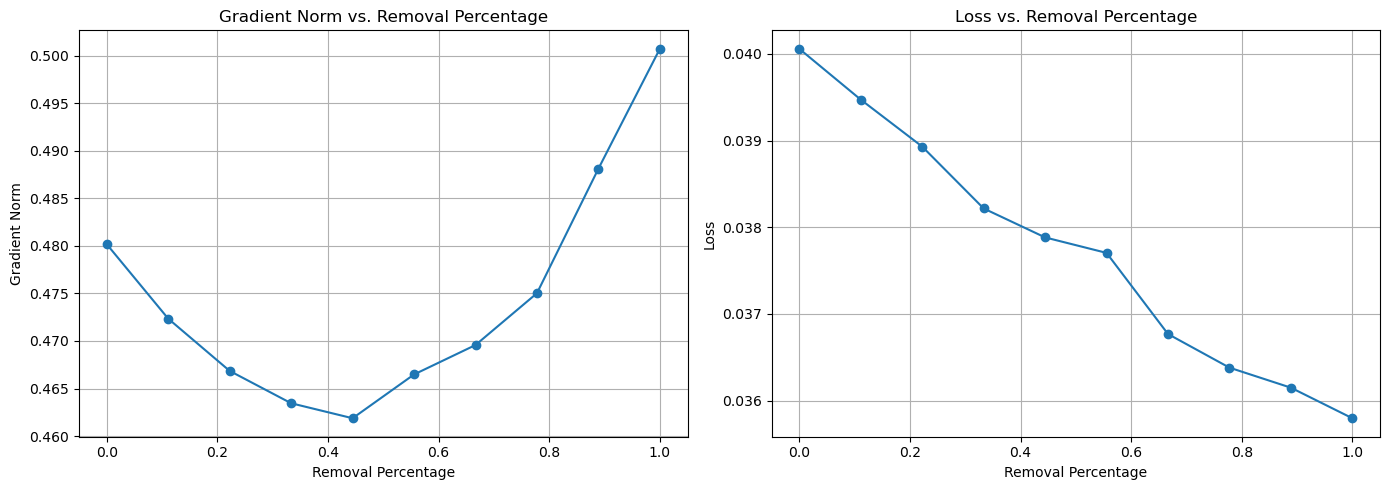

In [113]:
# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)

# Create plots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot gradient norm vs Removal percentage
axs[0].plot(results_df['removal_percentage'], results_df['gradient_norm'], 'o-')
axs[0].set_title('Gradient Norm vs. Removal Percentage')
axs[0].set_xlabel('Removal Percentage')
axs[0].set_ylabel('Gradient Norm')
axs[0].grid(True)

# Plot loss vs Removal percentage
axs[1].plot(results_df['removal_percentage'], results_df['loss'], 'o-')
axs[1].set_title('Loss vs. Removal Percentage')
axs[1].set_xlabel('Removal Percentage')
axs[1].set_ylabel('Loss')
axs[1].grid(True)

plt.tight_layout()
plt.show()

OUR METHOD

In [114]:
def compute_der(tensor1, tensor2):
    #Compute first derivative integrals of FI
    ratio = tensor1/tensor2
    return torch.log(ratio)+ 1/2 * (1-torch.pow(ratio,2))

def compute_true_info(hessian, hessian_unp, num_removed):
    information_true = [torch.empty_like(p) for p in hessian.values()]
    A_list = [torch.empty_like(p) for p in hessian.values()]
    B_list = [torch.empty_like(p) for p in hessian.values()]
    for i,k in enumerate(hessian.keys()): 
    #for i,_ in enumerate(A_list):
        print(k)
        ratio = torch.where(torch.logical_and(hessian[k]==0, hessian_unp[k]==0), 1, hessian_unp[k]/hessian[k])
        #A=1/2 * torch.log(ratio)/num_removed
        #B=1/2 * (1-torch.pow(ratio,2))/num_removed
        A=1/2 * torch.log(ratio)/num_removed
        B=1/2 * (1-ratio)/num_removed
        A[torch.isinf(A)]=0
        B[torch.isinf(B)]=0
        A_list[i]=torch.nan_to_num(A)
        B_list[i]=torch.nan_to_num(B)

    A_flat = torch.cat([A.flatten() for A in A_list])
    B_flat = torch.cat([B.flatten() for B in B_list])

    torch.cuda.empty_cache()
    device = torch.device("cpu")
    A_flat = A_flat.to(device)
    B_flat = B_flat.to(device)
    information_true = [torch.empty_like(p).to(device) for p in hessian.values()]
    hessian = [p.to(device) for p in hessian.values()]
    hessian_unp = [p.to(device) for p in hessian_unp.values()]

    information_true_view = [p.view(-1) for p in information_true]
    A_list_view = [p.view(-1) for p in A_list]
    B_list_view = [p.view(-1) for p in B_list]
    num_params = sum([p.numel() for p in hessian])
    track=0
    print("\nstart")
    for i,_ in enumerate(information_true_view):
        for j,_ in enumerate(information_true_view[i]):
            if (track+j)%(num_params//10)==0:
                print((track+j)//(num_params//100))

            temp=A_list_view[i][j]*A_flat + B_list_view[i][j]*B_flat + A_list_view[i][j]*B_flat + B_list_view[i][j]*A_flat
            information_true_view[i][j] = torch.sum(temp)+2*torch.pow(B_list_view[i][j],2)
        track+=information_true[i].numel()

    return information_true

In [115]:
num_rem = torch.as_tensor(num_remove_none)
info_true = compute_true_info(accumulated_diag_h, accumulated_diag_h_clean, num_rem)

NameError: name 'accumulated_diag_h' is not defined

In [ ]:
def sum_information_values(information):
    # Initialize an empty list to store all flattened tensors
    all_values = []

    # Iterate through each parameter's information tensor
    for tensor in information:
        # Flatten the tensor and add to our list
        temp=torch.nan_to_num(tensor.flatten())
        temp = temp[torch.isinf(temp)==0]
        temp = temp[temp!=0]
        all_values.append(temp)

    # Concatenate all tensors into one large tensor
    combined_tensor = torch.cat(all_values)
    print(len(combined_tensor))
    return combined_tensor

# 2. Plot the summed information
def plot_information(information):
    combined_tensor = sum_information_values(information)

    # Convert to numpy for plotting
    values = combined_tensor.detach().cpu().numpy()

    # Create the plot
    plt.figure(figsize=(10, 6))

    #Histogram
    plt.subplot(1, 2, 1)
    plt.hist(values, alpha=0.7, bins=50)
    plt.title('Distribution of Information Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    # Exclude outliers for the second plot (optional)
    q1, q3 = np.percentile(values, [15, 95])
    iqr = q3 - q1
    # lower_bound = q1 - 1.5 * iqr
    # upper_bound = q3 + 1.5 * iqr
    lower_bound = q1
    upper_bound = q3
    filtered_values = values[(values >= lower_bound) & (values <= upper_bound)]
    print(f"Number of outliers: {len(values) - len(filtered_values)}")

    # Filtered histogram (without outliers)
    plt.subplot(1, 2, 2)
    plt.hist(filtered_values, alpha=0.7, bins=50, color='green')
    plt.title('Distribution (Outliers Removed)')
    plt.xlabel('Value')

    plt.tight_layout()
    plt.show()

    # Print some statistics
    print(f"Sum of all information values: {combined_tensor.sum().item():.6f}")
    print(f"Mean: {combined_tensor.mean().item()}")
    print(f"Min: {combined_tensor.min().item()}")
    print(f"Max: {combined_tensor.max().item()}")
    print(f"Total number of values: {len(values)}")

    print(f"Sum of all information values: {filtered_values.sum().item():.6f}")
    print(f"Mean: {filtered_values.mean().item()}")
    print(f"Min: {filtered_values.min().item()}")
    print(f"Max: {filtered_values.max().item()}")
    print(f"Total number of values: {len(filtered_values)}")

    return combined_tensor.sum().item(), filtered_values.sum().item()

In [ ]:
plot_information(info)

print("Delta")
plot_information(delt)

print("Quad information")
plot_information(info_quad)



NameError: name 'info' is not defined

## 4. Unlearn the contribution of the target client
<a id='section_4'></a>

In [ ]:
num_updates_in_epoch = None
num_local_epochs_unlearn = 5
lr = 0.01
distance_threshold = 2.2
clip_grad = 5


initial_model = FLNet()
unlearned_model_dict = {}
for fusion_key in fusion_types_unlearn:
    if fusion_key == 'Retrain':
        unlearned_model_dict[fusion_key] = copy.deepcopy(initial_model.state_dict())

clean_accuracy_unlearn = {}
pois_accuracy_unlearn = {}
for fusion_key in fusion_types_unlearn:
    clean_accuracy_unlearn[fusion_key] = 0
    pois_accuracy_unlearn[fusion_key] = 0

for fusion_key in fusion_types:
    if fusion_key == 'Retrain':
        continue

    initial_model = FLNet()
    fedavg_model_state_dict = copy.deepcopy(model_dict[fusion_key])
    fedavg_model = copy.deepcopy(initial_model)
    fedavg_model.load_state_dict(fedavg_model_state_dict)

    party_models = copy.deepcopy(party_models_dict[fusion_key])
    party0_model = copy.deepcopy(party_models[0])

    #compute reference model
    #w_ref = N/(N-1)w^T - 1/(N-1)w^{T-1}_i = \sum{i \ne j}w_j^{T-1}
    model_ref_vec = num_parties / (num_parties - 1) * nn.utils.parameters_to_vector(fedavg_model.parameters()) \
                               - 1 / (num_parties - 1) * nn.utils.parameters_to_vector(party0_model.parameters())

    #compute threshold
    model_ref = copy.deepcopy(initial_model)
    nn.utils.vector_to_parameters(model_ref_vec, model_ref.parameters())

    eval_model = copy.deepcopy(model_ref)
    unlearn_clean_acc = Utils.evaluate(testloader, eval_model)
    print(f'Clean Accuracy for Reference Model = {unlearn_clean_acc}')
    unlearn_pois_acc = Utils.evaluate(testloader_poison, eval_model)
    print(f'Backdoor Accuracy for Reference Model = {unlearn_pois_acc}')

    dist_ref_random_lst = []
    for _ in range(10):
        dist_ref_random_lst.append(Utils.get_distance(model_ref, FLNet()))

    print(f'Mean distance of Reference Model to random: {np.mean(dist_ref_random_lst)}')
    threshold = np.mean(dist_ref_random_lst) / 3
    print(f'Radius for model_ref: {threshold}')
    dist_ref_party = Utils.get_distance(model_ref, party0_model)
    print(f'Distance of Reference Model to party0_model: {dist_ref_party}')


    ###############################################################
    #### Unlearning
    ###############################################################
    model = copy.deepcopy(model_ref)

    criterion = nn.CrossEntropyLoss()
    opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    model.train()
    flag = False
    for epoch in range(num_local_epochs_unlearn):
        print('------------', epoch)
        if flag:
            break
        for batch_id, (x_batch, y_batch) in enumerate(trainloader_lst[party_to_be_erased]):

            opt.zero_grad()

            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss_joint = -loss # negate the loss for gradient ascent
            loss_joint.backward()
            if clip_grad > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

            opt.step()

            with torch.no_grad():
                distance = Utils.get_distance(model, model_ref)
                if distance > threshold:
                    dist_vec = nn.utils.parameters_to_vector(model.parameters()) - nn.utils.parameters_to_vector(model_ref.parameters())
                    dist_vec = dist_vec/torch.norm(dist_vec)*np.sqrt(threshold)
                    proj_vec = nn.utils.parameters_to_vector(model_ref.parameters()) + dist_vec
                    nn.utils.vector_to_parameters(proj_vec, model.parameters())
                    distance = Utils.get_distance(model, model_ref)

            distance_ref_party_0 = Utils.get_distance(model, party0_model)
            print('Distance from the unlearned model to party 0:', distance_ref_party_0.item())

            if distance_ref_party_0 > distance_threshold:
                flag = True
                break

            if num_updates_in_epoch is not None and batch_id >= num_updates_in_epoch:
                break
    ####################################################################

    unlearned_model = copy.deepcopy(model)
    unlearned_model_dict[fusion_types_unlearn[1]] = unlearned_model.state_dict()

    eval_model = FLNet()
    eval_model.load_state_dict(unlearned_model_dict[fusion_types_unlearn[1]])
    unlearn_clean_acc = Utils.evaluate(testloader, eval_model)
    print(f'Clean Accuracy for UN-Local Model = {unlearn_clean_acc}')
    clean_accuracy_unlearn[fusion_types_unlearn[1]] =  unlearn_clean_acc
    pois_unlearn_acc = Utils.evaluate(testloader_poison, eval_model)
    print(f'Backdoor Accuracy for UN-Local Model = {pois_unlearn_acc}')
    pois_accuracy_unlearn[fusion_types_unlearn[1]] =  pois_unlearn_acc

## 5. Post-Training
<a id='section_5'></a>

In [ ]:
num_fl_after_unlearn_rounds = num_fl_rounds
num_updates_in_epoch = 50
num_local_epochs = 1

clean_accuracy_unlearn_fl_after_unlearn = {}
pois_accuracy_unlearn_fl_after_unlearn = {}
loss_unlearn = {}
for fusion_key in fusion_types_unlearn:
    clean_accuracy_unlearn_fl_after_unlearn[fusion_key] = np.zeros(num_fl_after_unlearn_rounds)
    pois_accuracy_unlearn_fl_after_unlearn[fusion_key] = np.zeros(num_fl_after_unlearn_rounds)
    loss_unlearn[fusion_key] = np.zeros(num_fl_after_unlearn_rounds)


for round_num in range(num_fl_after_unlearn_rounds):

    local_training = LocalTraining(num_updates_in_epoch=num_updates_in_epoch, num_local_epochs=num_local_epochs)

    for fusion_key in fusion_types_unlearn:
        # Reduce num_parties by 1 to remove the erased party
        fusion = FL_round_fusion_selection(num_parties=num_parties - 1, fusion_key=fusion_key)

        current_model_state_dict = copy.deepcopy(unlearned_model_dict[fusion_key])
        current_model = FLNet()
        current_model.load_state_dict(current_model_state_dict)

        ##################### Local Training Round #############################
        party_models = []
        party_losses = []
        for party_id in range(1, num_parties):
            model = copy.deepcopy(current_model)
            model_update, party_loss = local_training.train(model=model,
                                        trainloader=trainloader_lst[party_id],
                                        criterion=None, opt=None)

            party_models.append(copy.deepcopy(model_update))
            party_losses.append(party_loss)

        loss_unlearn[fusion_key][round_num] = np.mean(party_losses)
        ######################################################################

        current_model_state_dict = fusion.fusion_algo(party_models=party_models, current_model=current_model)
        unlearned_model_dict[fusion_key] = copy.deepcopy(current_model_state_dict)
        party_models_dict[fusion_key] = party_models

        eval_model = FLNet()
        eval_model.load_state_dict(current_model_state_dict)
        unlearn_clean_acc = Utils.evaluate(testloader, eval_model)
        print(f'Global Clean Accuracy {fusion_key}, round {round_num} = {unlearn_clean_acc}')
        clean_accuracy_unlearn_fl_after_unlearn[fusion_key][round_num] = unlearn_clean_acc
        unlearn_pois_acc = Utils.evaluate(testloader_poison, eval_model)
        print(f'Global Backdoor Accuracy {fusion_key}, round {round_num} = {unlearn_pois_acc}')
        pois_accuracy_unlearn_fl_after_unlearn[fusion_key][round_num] = unlearn_pois_acc


Compare the performance of the proposed unlearning method with retraining from scratch (baseline)

In [ ]:
import matplotlib.pyplot as plt

fl_rounds = [i for i in range(1, num_fl_rounds + 1)]

plt.plot(fl_rounds, clean_accuracy_unlearn_fl_after_unlearn['Unlearn'], 'ro--', linewidth=2, markersize=12, label='UN-Clean Acc')
plt.plot(fl_rounds, pois_accuracy_unlearn_fl_after_unlearn['Unlearn'], 'gx--', linewidth=2, markersize=12, label='UN-Backdoor Acc')
plt.plot(fl_rounds, clean_accuracy_unlearn_fl_after_unlearn['Retrain'], 'm^-', linewidth=2, markersize=12, label='Retrain-Clean Acc')
plt.plot(fl_rounds, pois_accuracy_unlearn_fl_after_unlearn['Retrain'], 'c+-', linewidth=2, markersize=12, label='Retrain-Backdoor Acc')
plt.xlabel('Training Rounds')
plt.ylabel('Accuracy')
plt.grid()
plt.ylim([0, 100])
plt.xlim([1, 10])
plt.legend()
plt.show()